
This is a small analysis based on the paper [A Watermark for Large Language Models](https://arxiv.org/pdf/2301.10226.pdf). The paper elucidates on the potential harms of large language models and how they can be mitigated by watermarking their output. This involves embedding signals into the generated text which remain invisible to human observers but can be algorithmically detected from a concise span of tokens. The proposed watermarking framework is specifically tailored for proprietary language models. Remarkably, the embedding of the watermark results in an almost imperceptible impact on the overall text quality. What's more, the watermark can be efficiently identified using an open-source algorithm without necessitating access to the model's API or its parameters.

The mechanism of the watermark is intriguing. It operates by choosing a randomized set of "green" tokens prior to generating a word. These green tokens are then gently favored during the sampling phase. The paper also offers a statistical test to detect the watermark, providing interpretable p-values. Furthermore, it introduces an information-theoretic framework to study the sensitivity of the watermark. Testing was performed on a multi-billion parameter model from the Open Pretrained Transformer (OPT) family, offering insights into its robustness and security.

A complementary study on "[Watermarking Conditional Text Generation for AI Detection](https://arxiv.org/pdf/2307.13808.pdf)" underlines challenges associated with a pronounced setback in the realm of conditional text generation. Notably, applying watermarking algorithms indiscriminately to Conditional Text Generation (CTG) tasks can lead to significant performance degradation. Specifically, the absence of task-oriented adaptations results in marked performance reductions: a staggering 96.99% plunge with hard watermarks and a 27.54% descent with soft watermarks, as observed in tasks like summarization and data-to-text generation.

In this Colab notebook, I aim to delve deeper into the realm of watermarking algorithms within the context of Conditional Text Generation (CTG) using BART model and CNN dataset based on "[A Watermark for Large Language Models](https://arxiv.org/pdf/2301.10226.pdf)" methods, and see the performance of the proposed methods on BART model and text summarization.

In [ ]:
%%capture
!pip install sentencepiece
!pip install transformers
!pip install datasets
!pip install rouge_score

In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration
from datasets import load_dataset
import hashlib
import torch.nn.functional as F
import random
import math
import torch
import pandas as pd

# Initialize model and tokenizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")


model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")

model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [ ]:
import random
# Load CNN dataset
dataset = load_dataset("cnn_dailymail", "3.0.0", split="test")

dataset_list = [{"article": entry['article'], "highlights": entry['highlights']} for entry in dataset]

# Shuffle the list
random.shuffle(dataset_list)

# Limit to the first 100 rows after shuffling
cnn_docs = [doc['article'] for doc in dataset_list][:100]
cnn_summaries = [summary['highlights'] for summary in dataset_list][:100]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [ ]:
from statistics import mean
import numpy as np

# Tokenize summaries by splitting on spaces
tokenized_summaries = [summary.split() for summary in cnn_summaries]

# Calculate number of tokens for each summary
num_tokens_per_summary = [len(tokens) for tokens in tokenized_summaries]

# Calculate the average
average_tokens = mean(num_tokens_per_summary)

print(f"Average number of tokens per summary: {average_tokens:.2f}")

Average number of tokens per summary: 58.46


In the referenced study, the authors detailed their approach to mimic a variety of genuine language modeling situations. To achieve this, they opted to segment a random collection of texts from the news-related segment of the C4 dataset. From each of these randomly chosen passages, a predetermined number of tokens were snipped from the conclusion, designating them as "baseline" completions. For their experiments employing multinomial sampling, the authors sourced examples from their dataset until they amassed a minimum of 500 generations, each measuring T = 200 tokens in length. Additionally, to counteract beam search's inclination for crafting shorter sequences, they omitted the EOS token during the generation process.

Contrastingly, for our analysis, we'll pivot to the CNN summarization dataset. Given the context, a token count of 200 seems excessive. Hence, based on the average token count observed in the summaries, which hovers around 55, I've elected to use this as our benchmark.

Moreover, because of computational power constraints, I only processed 100 entries for each experiment.

Additionally, we produce non-watermarked texts using the same search algorithm that we employ for generating watermarked texts, ensuring a balanced comparison.

In [ ]:
def Z(ids, vocab_size: int, gamma: float = 0.5, hash_function=hashlib.sha256) -> float:
    ids = [model.config.bos_token_id] + ids
    T = len(ids)
    green_list_size = int(gamma * vocab_size)
    in_green_list = 1
    for t in range(T-1):
        # Regenerate the green list for the current token based on its preceding token
        hasher = hash_function()
        hasher.update(str(ids[t]).encode())
        digest = hasher.hexdigest()
        rng = random.Random(digest)
        green_tokens = rng.sample(range(vocab_size),  green_list_size)

        if ids[t+1] in green_tokens:
            in_green_list += 1


    z = (in_green_list - gamma * T) / np.sqrt(T * gamma * (1-gamma))
    return z

In [ ]:
from rouge_score import rouge_scorer

@torch.no_grad()
def process_and_score_summaries(watermark_algorithm,cnn_docs, cnn_summaries, tokenizer, model, MAX_MODEL_LENGTH=1024, batch_size=10,gamma=0.5,delta=None,T=None,strategy='multinomial'):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Lists to store results for original, no watermark, and watermarked texts
    original_summaries, nowatermark_summaries, watermarked_summaries = [], [], []
    z_statistics_original, z_statistics_watermarked, z_statistics_nowatermark = [], [], []
    rouge1_scores_watermarked, rouge2_scores_watermarked, rougeL_scores_watermarked = [], [], []
    rouge1_scores_nowatermark, rouge2_scores_nowatermark, rougeL_scores_nowatermark = [], [], []

    # Helper function to batch encode
    def batch_encode(docs, tokenizer, max_length):
        return tokenizer(docs, truncation=True, padding='longest', max_length=max_length, return_tensors='pt').input_ids.to(device)

    # Batch encoding
    encoded_batches = [batch_encode(cnn_docs[i:i+batch_size], tokenizer, MAX_MODEL_LENGTH) for i in range(0, len(cnn_docs), batch_size)]
    # Add a list to store perplexities
    perplexities_watermarked = []

    # Process in batches
    for batch in tqdm(encoded_batches, desc="Processing batches", ncols=100):
        if delta!=None:
          watermarked_ids_batch = [watermark_algorithm(model, doc.unsqueeze(0),gamma=gamma,T=T,delta=delta,strategy=strategy) for doc in batch]
        else:
          watermarked_ids_batch = [watermark_algorithm(model, doc.unsqueeze(0),gamma=gamma,T=T,strategy=strategy) for doc in batch]
        for idx, (doc, watermarked_ids) in enumerate(zip(batch, watermarked_ids_batch)):  # We're iterating over both the original document and its watermarked version
            original_summary = cnn_summaries[idx]

            # We need to generate no watermarked texts with the same search algorithm we used to generate watermarked texts to have a fair comparison
            if strategy=='multinomial':
              summary_ids = model.generate(doc.unsqueeze(0),  do_sample=True, num_beams=1, min_length=T, max_length=T, length_penalty=1.0, early_stopping =False)
            elif strategy=='greedy':
              summary_ids = model.generate(doc.unsqueeze(0),  do_sample=False, num_beams=1, min_length=T, max_length=T, length_penalty=1.0, early_stopping =False)
            nowatermark_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
            watermarked_summary = tokenizer.decode(watermarked_ids)

            # Compute Z-statistic

            z_statistic_original = Z( tokenizer.encode(original_summary), model.config.vocab_size, gamma=gamma)

            z_statistic_nowatermark = Z( summary_ids[0].tolist(), model.config.vocab_size, gamma=gamma)

            z_statistic_watermarked = Z( watermarked_ids, model.config.vocab_size,gamma=gamma)

            # Compute Rouge scores
            scores_nowatermark = scorer.score( original_summary, nowatermark_summary)
            scores_watermarked = scorer.score( original_summary, watermarked_summary)

            # Append results to lists
            original_summaries.append(original_summary)
            nowatermark_summaries.append(nowatermark_summary)
            watermarked_summaries.append(watermarked_summary)
            z_statistics_original.append(z_statistic_original)
            z_statistics_nowatermark.append(z_statistic_nowatermark)
            z_statistics_watermarked.append(z_statistic_watermarked)
            rouge1_scores_nowatermark.append(scores_nowatermark['rouge1'].fmeasure)
            rouge1_scores_watermarked.append(scores_watermarked['rouge1'].fmeasure)
            rouge2_scores_nowatermark.append(scores_nowatermark['rouge2'].fmeasure)
            rouge2_scores_watermarked.append(scores_watermarked['rouge2'].fmeasure)
            rougeL_scores_nowatermark.append(scores_nowatermark['rougeL'].fmeasure)
            rougeL_scores_watermarked.append(scores_watermarked['rougeL'].fmeasure)

            # Compute perplexity for watermarked summary
            with torch.no_grad():
                watermarked_ids = torch.tensor(watermarked_ids).unsqueeze(0).to(device)
                outputs = model(batch, labels=watermarked_ids)
                log_likelihood = outputs.loss * watermarked_ids.shape[1]
            perplexity = torch.exp(-log_likelihood / watermarked_ids.shape[1])
            perplexities_watermarked.append(perplexity.item())

    return (original_summaries, nowatermark_summaries, watermarked_summaries,
            z_statistics_original, z_statistics_nowatermark, z_statistics_watermarked,
            rouge1_scores_watermarked,  rouge2_scores_watermarked, rougeL_scores_watermarked,
            rouge1_scores_nowatermark,rouge2_scores_nowatermark,rougeL_scores_nowatermark,perplexities_watermarked)

For the sake of simplicity, I employed the summarization model (BART in this instance) to compute the perplexity, rather than using the OPT-2.7B model as introduced in the original paper.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_results(original_summaries, nowatermark_summaries, watermarked_summaries,
            z_statistics_original, z_statistics_nowatermark, z_statistics_watermarked,
            rouge1_scores_watermarked,  rouge2_scores_watermarked, rougeL_scores_watermarked,
            rouge1_scores_nowatermark,rouge2_scores_nowatermark,rougeL_scores_nowatermark,perplexities_watermarked):

    # Create a DataFrame from the results
    df = pd.DataFrame({
        'Original Summary': original_summaries,
        'No Watermarked Summary': nowatermark_summaries,
        'Watermarked Summary': watermarked_summaries,
        'Z-statistic Original': z_statistics_original,
        'Z-statistic No Watermark': z_statistics_nowatermark,
        'Z-statistic Watermarked': z_statistics_watermarked,
        'ROUGE-1 Watermarked': rouge1_scores_watermarked,
        'ROUGE-2 Watermarked': rouge2_scores_watermarked,
        'ROUGE-L Watermarked': rougeL_scores_watermarked,
        'ROUGE-1 nowatermark': rouge1_scores_nowatermark,
        'ROUGE-2 nowatermark': rouge2_scores_nowatermark,
        'ROUGE-L nowatermark': rougeL_scores_nowatermark,
        'Watermarked Perplexities':perplexities_watermarked
    })

    # Plot histograms
    plt.figure(figsize=(14, 20))

    # Z-statistic distribution
    plt.subplot(4, 2, 1)
    plt.hist(z_statistics_original, bins=30, color='green', edgecolor='black', alpha=0.5, label="Original Summary")
    plt.hist(z_statistics_nowatermark, bins=30, color='red', edgecolor='black', alpha=0.5, label="No Watermark")
    plt.hist(z_statistics_watermarked, bins=30, color='skyblue', edgecolor='black', alpha=0.5, label="Watermarked")
    plt.title('Z-statistic Distribution')
    plt.xlabel('Z-statistic')
    plt.ylabel('Frequency')
    plt.legend()

     # ROUGE-1 distribution
    plt.subplot(4, 2, 2)
    plt.hist(rouge1_scores_watermarked, bins=30, color='salmon', edgecolor='black', alpha=0.5, label="Watermarked")
    plt.hist(rouge1_scores_nowatermark, bins=30, color='tan', edgecolor='black', alpha=0.5, label="No Watermark")
    plt.title('ROUGE-1 Score Distribution')
    plt.xlabel('ROUGE-1 Score')
    plt.ylabel('Frequency')
    plt.legend()

    # ROUGE-2 distribution
    plt.subplot(4, 2, 3)
    plt.hist(rouge2_scores_watermarked, bins=30, color='lightgreen', edgecolor='black', alpha=0.5, label="Watermarked")
    plt.hist(rouge2_scores_nowatermark, bins=30, color='tan', edgecolor='black', alpha=0.5, label="No Watermark")
    plt.title('ROUGE-2 Score Distribution')
    plt.xlabel('ROUGE-2 Score')
    plt.ylabel('Frequency')
    plt.legend()

    # ROUGE-L distribution
    plt.subplot(4, 2, 4)
    plt.hist(rougeL_scores_watermarked, bins=30, color='gold', edgecolor='black', alpha=0.5, label="Watermarked")
    plt.hist(rougeL_scores_nowatermark, bins=30, color='tan', edgecolor='black', alpha=0.5, label="No Watermark")
    plt.title('ROUGE-L Score Distribution')
    plt.xlabel('ROUGE-L Score')
    plt.ylabel('Frequency')
    plt.legend()


   # Average, SD, & Variance for Z-statistics
    means = [np.mean(z_statistics_nowatermark), np.mean(z_statistics_watermarked)]
    sds = [np.std(z_statistics_nowatermark), np.std(z_statistics_watermarked)]
    variances = [s**2 for s in sds]  # Variance is the square of standard deviation
    labels = ['Non-watermarked', 'Watermarked']
    x = np.arange(len(labels))

    plt.subplot(4, 2, 5)
    plt.bar(x, means, yerr=sds, capsize=10, color=['gray', 'skyblue'], alpha=0.7)
    plt.title('Average & SD of Z-statistics')
    plt.xticks(x, labels)
    plt.ylabel('Value')
    for i, (mean_val, var_val) in enumerate(zip(means, variances)):
        plt.text(i, mean_val + 0.2, f"Mean: {mean_val:.2f}", ha='center', va='bottom')
        plt.text(i, mean_val - 0.2, f"Var: {var_val:.2f}", ha='center', va='bottom')  # Display variance below mean value


    # Average & SD for ROUGE scores
    rouge_means_watermark = [np.mean(rouge1_scores_watermarked), np.mean(rouge2_scores_watermarked), np.mean(rougeL_scores_watermarked)]
    rouge_sds_watermarked = [np.std(rouge1_scores_watermarked), np.std(rouge2_scores_watermarked), np.std(rougeL_scores_watermarked)]
    rouge_means_nowatermark = [np.mean(rouge1_scores_nowatermark), np.mean(rouge2_scores_nowatermark), np.mean(rougeL_scores_nowatermark)]
    rouge_sds_nowatermark = [np.std(rouge1_scores_nowatermark), np.std(rouge2_scores_nowatermark), np.std(rougeL_scores_nowatermark)]
    rouge_labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
    rouge_x = np.arange(len(rouge_labels))


    plt.subplot(4, 2, 6)
    plt.bar(rouge_x, rouge_means_nowatermark, yerr=rouge_sds_nowatermark, capsize=10, color=['salmon', 'lightgreen', 'gold'], alpha=0.7)
    plt.title('Average & SD of ROUGE scores (No Watermarked)')
    plt.xticks(rouge_x, rouge_labels)
    plt.ylabel('Value')
    for i, v in enumerate(rouge_means_nowatermark):
        plt.text(i, v , f"{v:.2f}", ha='center', va='bottom')



    plt.subplot(4, 2, 7)
    plt.bar(rouge_x, rouge_means_watermark, yerr=rouge_sds_watermarked, capsize=10, color=['salmon', 'lightgreen', 'gold'], alpha=0.7)
    plt.title('Average & SD of ROUGE scores (Watermarked)')
    plt.xticks(rouge_x, rouge_labels)
    plt.ylabel('Value')
    for i, v in enumerate(rouge_means_watermark):
        plt.text(i, v , f"{v:.2f}", ha='center', va='bottom')


    # Scatter plot: Average z-score vs Language model perplexity
    plt.subplot(4, 2, 8)
    plt.scatter(z_statistics_watermarked, perplexities_watermarked, color='purple', alpha=0.5)
    plt.title('Average Z-score and LM Perplexity')
    plt.xlabel('Average Z-statistic (Watermarked)')
    plt.ylabel('Language Model Perplexity (Watermarked)')
    plt.grid(True, which="both", ls="--", c='0.7')

    # Display the plots
    plt.tight_layout()
    plt.show()
    return df

# Algorithm 1 (Hard Watermak - Multinomial)



The red list, being randomly selected, means a natural writer is likely to break its rules with about half of their tokens. In contrast, a watermarked model doesn't produce any violations. The likelihood that a natural source writes T tokens without breaching the red list rule is 1/2^T. This probability becomes minuscule even for short texts, making it feasible to detect watermarks in brief pieces, such as synthetic tweets.

For a more fortified detection method, a one proportion z-test is utilized to assess the null hypothesis. When this hypothesis holds, the expected number of green list tokens, symbolized as |s|G, averages to T/2 with a variance of T/4. The test's z-statistic is formulated as z = 2(|s|G - T/2)/√T. The watermark is identified, and the null hypothesis is discarded if z surpasses a predetermined threshold.

In [ ]:
from tqdm import tqdm
@torch.no_grad()
def add_hard_watermark(model, input_ids, strategy='multinomial', T=55, gamma=0.5, hash_function=hashlib.sha256):

    """
    Generate text using a model while obeying a "hard red list".

    Parameters:
    - model: The language model.
    - input_ids: Tensor containing the initial input for the generation.
    - strategy: The token generation strategy ('multinomial', 'greedy').
    - T: Desired number of tokens to generate.
    - gamma: Proportion for the green list.
    - max_length: Maximum length of the generated sequence.
    - hash_function: Hash function used for watermarking.

    Returns:
    - List of token IDs that adhere to the red list constraints.
    """

    assert strategy in ['multinomial', 'greedy'], "Invalid strategy. Choose from 'multinomial', 'greedy'"

    model = model.to(input_ids.device)

    vocab_size = model.config.vocab_size
    green_list_calculation = int(gamma * vocab_size)

    device = input_ids.device
    encoder_input_ids = input_ids
    end_of_text_token_id = model.config.eos_token_id

    loop_limit = T
    decoder_input_ids = torch.zeros((1, loop_limit), dtype=torch.long, device=device)
    decoder_input_ids[0, 0] = model.config.bos_token_id  # initialize with the beginning-of-sentence token

    watermarked_tokens = []

    for i in range(loop_limit-1):
        hasher = hash_function()
        hasher.update(str(decoder_input_ids[0, i].item()).encode())
        digest = hasher.hexdigest()
        rng = random.Random(digest)

        green_tokens = rng.sample(range(vocab_size), green_list_calculation)

        outputs = model(encoder_input_ids, decoder_input_ids=decoder_input_ids[:, :i+1])
        probabilities = F.softmax(outputs.logits[:, -1, :], dim=-1)
        green_probabilities = probabilities[0, green_tokens]

        # Normalize the green probabilities
        green_probabilities /= green_probabilities.sum()

        # Token generation based on strategy
        if strategy == 'multinomial':
            next_token_idx = torch.multinomial(green_probabilities, 1).item()
        elif strategy == 'greedy':
            next_token_idx = torch.argmax(green_probabilities).item()

        next_token = green_tokens[next_token_idx]
        watermarked_tokens.append(next_token)
        decoder_input_ids[0, i+1] = next_token

        # Condition to break the loop if end-of-text token is reached and T is not defined
        if T is None and next_token == end_of_text_token_id:
            break

    return watermarked_tokens

In [ ]:
(original_summaries_1, nowatermark_summaries_1, watermarked_summaries_1,
            z_statistics_original_1, z_statistics_nowatermark_1, z_statistics_watermarked_1,
            rouge1_scores_watermarked_1,  rouge2_scores_watermarked_1, rougeL_scores_watermarked_1,
            rouge1_scores_nowatermark_1,rouge2_scores_nowatermark_1,rougeL_scores_nowatermark_1,perplexities_watermarked_1) = process_and_score_summaries(add_hard_watermark, cnn_docs, cnn_summaries, tokenizer, model,strategy='multinomial',T=55)

Processing batches: 100%|███████████████████████████████████████████| 10/10 [14:25<00:00, 86.53s/it]


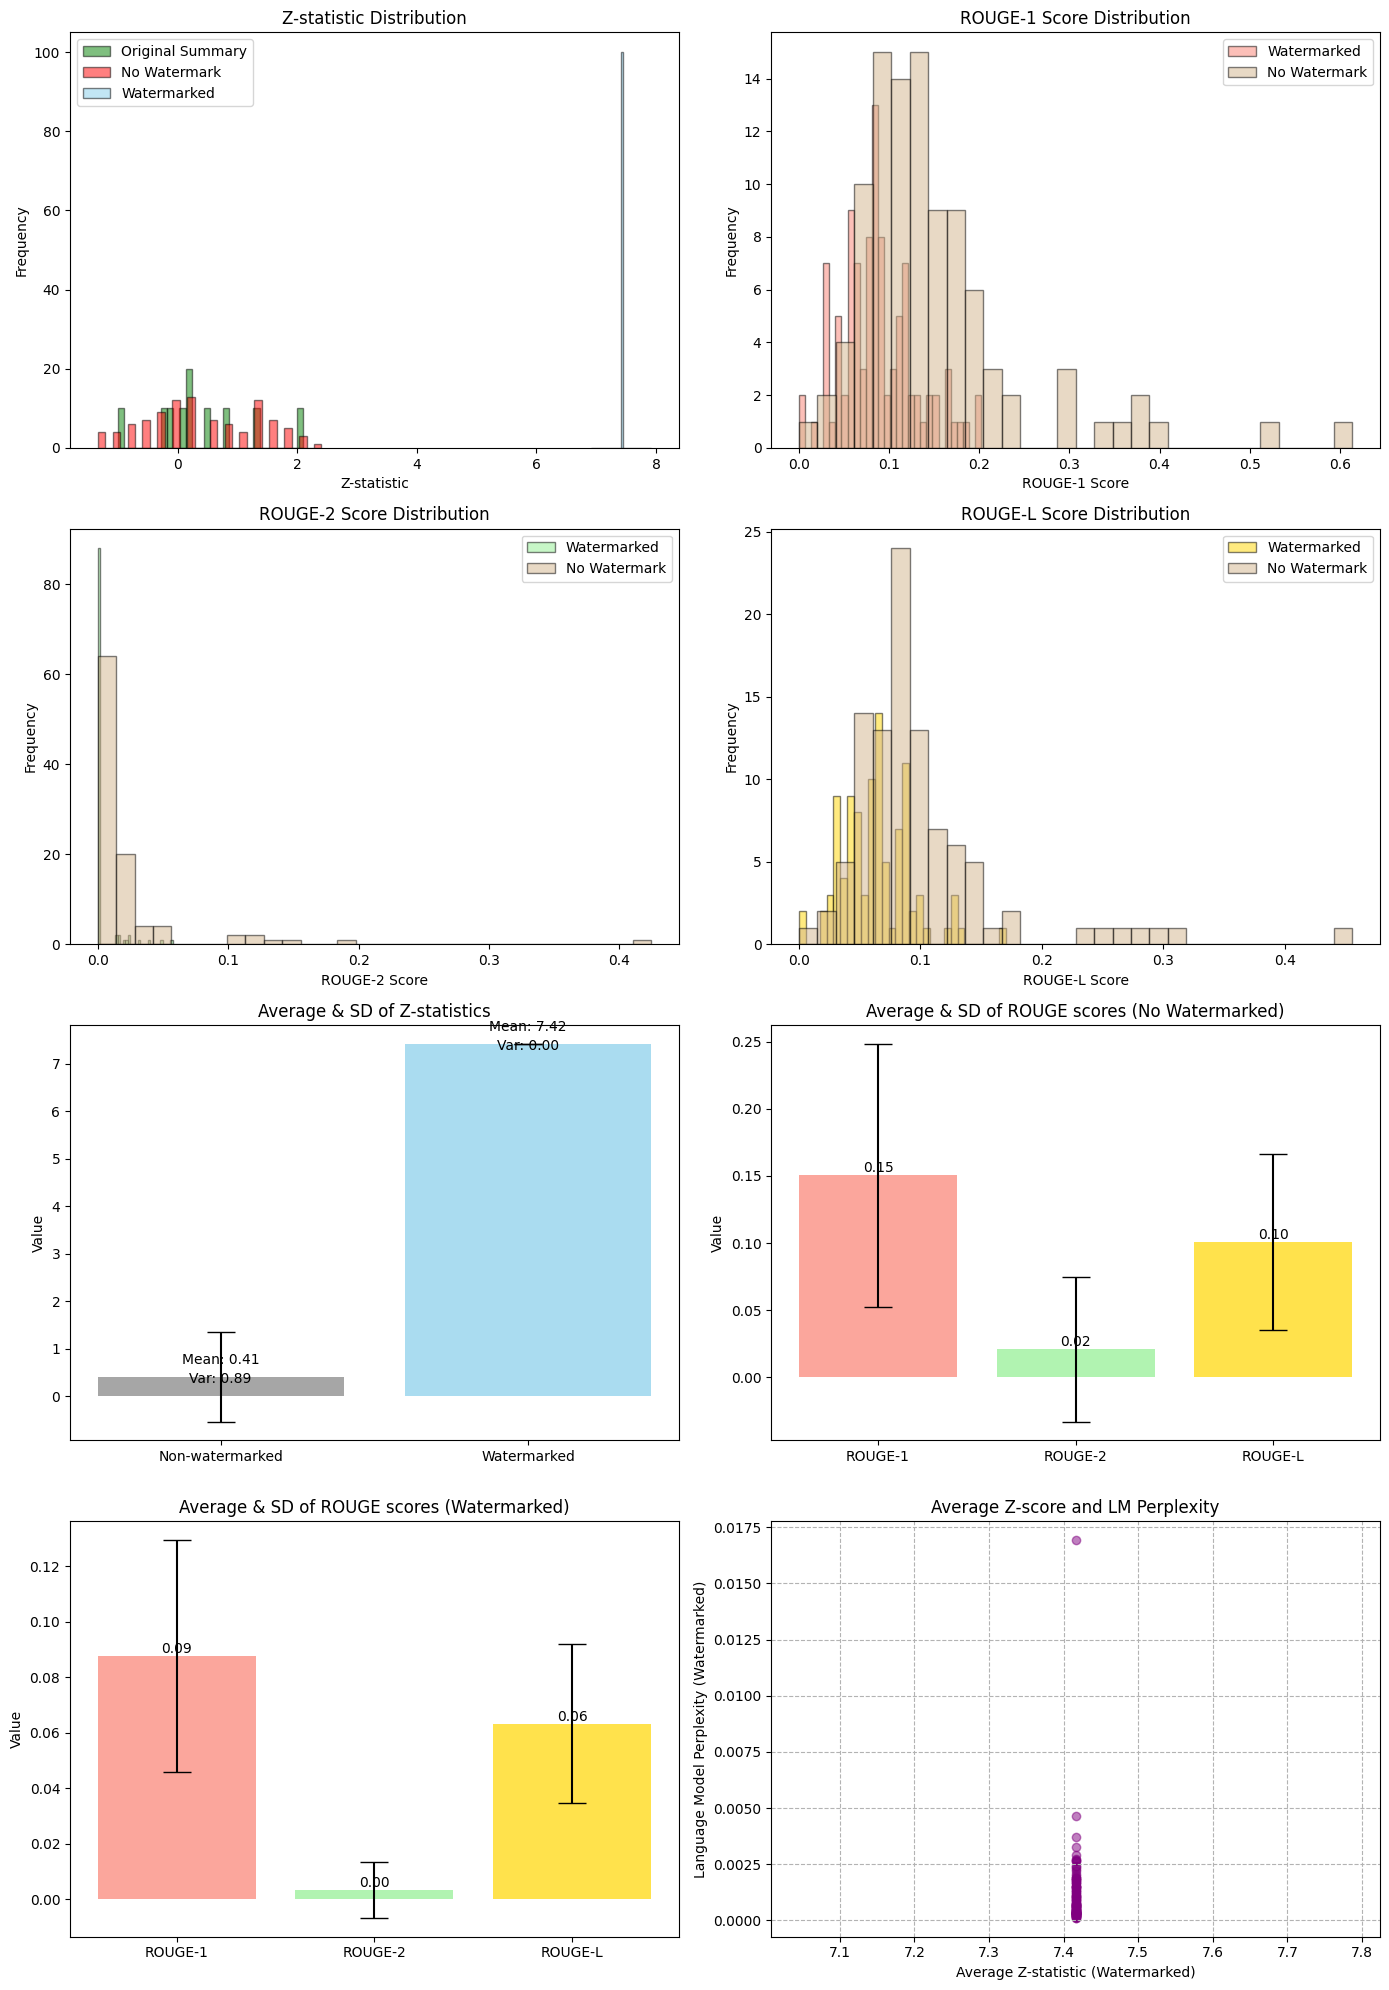

In [ ]:
import numpy as np

df_1 = analyze_results(
            original_summaries_1, nowatermark_summaries_1, watermarked_summaries_1,
            z_statistics_original_1, z_statistics_nowatermark_1, z_statistics_watermarked_1,
            rouge1_scores_watermarked_1,  rouge2_scores_watermarked_1, rougeL_scores_watermarked_1,
            rouge1_scores_nowatermark_1,rouge2_scores_nowatermark_1,rougeL_scores_nowatermark_1,perplexities_watermarked_1
)

In [ ]:
df_1.head()

,Original Summary,No Watermarked Summary,Watermarked Summary,Z-statistic Original,Z-statistic No Watermark,Z-statistic Watermarked,ROUGE-1 Watermarked,ROUGE-2 Watermarked,ROUGE-L Watermarked,ROUGE-1 nowatermark,ROUGE-2 nowatermark,ROUGE-L nowatermark,Watermarked Perplexities
0,"The average cost of the big day has hit £25,00...",Wedding season is fast approaching but average...,Deb Vita.com asks: Would you buy Utilitarian ...,0.140028,1.336306,7.416198,0.063492,0.000000,0.063492,0.406250,0.129032,0.312500,0.000320
1,In the midst of the worst storm in New South W...,Twitter users found some of the most shocking ...,<s><s><s>Google Transcon is powered has excuse...,2.092457,0.267261,7.416198,0.120000,0.020408,0.080000,0.336634,0.101010,0.178218,0.002435
2,"Ashley Pegram, from Summerville, South Carolin...","Ashley Pegram, a 28-year-old mother-of-three, ...","<s><s><s><s><s><s>estyle, announcement says th...",0.091670,0.000000,7.416198,0.116788,0.000000,0.087591,0.353846,0.125000,0.230769,0.001423
3,Auctioneer gave painting an estimated value of...,painting was thought to be the work of a foll...,<s> retreating stars reveals plans to Troll in...,1.305460,2.138090,7.416198,0.086957,0.000000,0.043478,0.613861,0.424242,0.455446,0.001046
4,"Thomas Brock, 30, was fatally shot following a...","Thomas Brock, 30, was fatally shot at his home...",A. First Armored Ax hybrid soldiers were pitte...,-0.250000,-0.267261,7.416198,0.085106,0.000000,0.063830,0.531915,0.195652,0.276596,0.000676


The code doesn't account for scenarios where the model could repeatedly produce the same tokens, stemming from the predictable way the green list is created using the hash of the preceding token.

In [ ]:
def rouge_means(df):
  # Compute the mean for the ROUGE scores
  rouge_means = {
      'ROUGE-1 Watermarked': df['ROUGE-1 Watermarked'].mean(),
      'ROUGE-2 Watermarked': df['ROUGE-2 Watermarked'].mean(),
      'ROUGE-L Watermarked': df['ROUGE-L Watermarked'].mean(),
      'ROUGE-1 nowatermark': df['ROUGE-1 nowatermark'].mean(),
      'ROUGE-2 nowatermark': df['ROUGE-2 nowatermark'].mean(),
      'ROUGE-L nowatermark': df['ROUGE-L nowatermark'].mean()
  }
  return rouge_means

print(rouge_means(df_1))

{'ROUGE-1 Watermarked': 0.0877378046926053, 'ROUGE-2 Watermarked': 0.003265801241978515, 'ROUGE-L Watermarked': 0.06333036158789856, 'ROUGE-1 nowatermark': 0.1504749795702571, 'ROUGE-2 nowatermark': 0.020711356784779388, 'ROUGE-L nowatermark': 0.10069307994134047}


In [ ]:
percentage = (df_1[df_1["Z-statistic Watermarked"] > 4].shape[0] / df_1.shape[0]) * 100

print(f"{percentage:.2f}% of Z-statistic Watermarked values are greater than 4.")

100.00% of Z-statistic Watermarked values are greater than 4.


**Z-statistic Distribution:**

From the charts, it's evident that all watermarked texts have a Z-statistic with the value of 6, and most of the original summaries have a Z-statistic closer to 0.

**ROUGE-1, ROUGE-2, and ROUGE-L Score Distribution:**

These histograms show the frequency distributions of the respective ROUGE scores for watermarked and non-watermarked texts. ROUGE scores are commonly used for evaluating the quality of summaries by comparing them to reference summaries.
Generally, watermarked texts tend to have lower ROUGE scores than non-watermarked texts, indicating that watermarking may reduce the quality or relevance of the generated summaries.

**Average & SD of ROUGE scores (No Watermarked):**


This bar chart presents the average and SD for the three types of ROUGE scores (ROUGE-1, ROUGE-2, and ROUGE-L) for non-watermarked texts. The bars suggest that the ROUGE scores for watermarked texts are marginally lower, and the scores for both watermarked and non-watermarked texts tend to be low overall.

**Average & SD of ROUGE scores (Watermarked):**

Similar to the previous chart, but for watermarked texts. The averages for the ROUGE scores are visibly lower for watermarked texts, suggesting a decline in the quality or relevance of summaries after watermarking.

The ROUGE score distributions (1, 2, and L) depict how watermarked texts generally have a lower ROUGE score, indicating a decrease in the quality of the generated summaries post-watermarking. The box plots showcase greater variability in the Z-statistic with a slighltly higher mean (-0.2 in compare to -0.3) for the watermarked data.

# Algorithm 1 (Hard Watermak - Greedy + Integrated code to avoid token repetition)


To enhance the quality of texts watermarked using the hard watermark algorithm, we could employ a greedy search method and integrate a code that prevents token repetition. Using greedy search in most of the language models leads to token repetition, so we have to find a way to avoid that. By excluding recent tokens from the green list, we can achieve this.

In [ ]:
@torch.no_grad()
def add_hard_watermark_no_token_repetition(model, input_ids, strategy='multinomial', T=100, gamma=0.5, hash_function=hashlib.sha256):

    """
    Generate text using a model while obeying a "hard red list".

    Parameters:
    - model: The language model.
    - input_ids: Tensor containing the initial input for the generation.
    - strategy: The token generation strategy ('multinomial', 'greedy').
    - T: Desired number of tokens to generate.
    - gamma: Proportion for the green list.
    - hash_function: Hash function used for watermarking.

    Returns:
    - List of token IDs that adhere to the red list constraints.
    """

    assert strategy in ['multinomial', 'greedy'], "Invalid strategy. Choose from 'multinomial', 'greedy'"

    model = model.to(input_ids.device)

    vocab_size = model.config.vocab_size
    green_list_calculation = int(gamma * vocab_size)

    device = input_ids.device
    encoder_input_ids = input_ids
    end_of_text_token_id = model.config.eos_token_id

    loop_limit = T
    decoder_input_ids = torch.zeros((1, loop_limit), dtype=torch.long, device=device)
    decoder_input_ids[0, 0] = model.config.bos_token_id  # initialize with the beginning-of-sentence token

    watermarked_tokens = []
    recent_tokens = set()

    for i in range(loop_limit-1):
        hasher = hash_function()
        hasher.update(str(decoder_input_ids[0, i].item()).encode())
        digest = hasher.hexdigest()
        rng = random.Random(digest)

        green_tokens = [token for token in rng.sample(range(vocab_size), green_list_calculation) if token not in recent_tokens]

        if not green_tokens:
            break  # no valid tokens left to choose from

        outputs = model(encoder_input_ids, decoder_input_ids=decoder_input_ids[:, :i+1])
        probabilities = F.softmax(outputs.logits[:, -1, :], dim=-1)
        green_probabilities = probabilities[0, green_tokens]

        # Normalize the green probabilities
        green_probabilities /= green_probabilities.sum()

        # Token generation based on strategy
        if strategy == 'multinomial':
            next_token_idx = torch.multinomial(green_probabilities, 1).item()
        elif strategy == 'greedy':
            next_token_idx = torch.argmax(green_probabilities).item()

        next_token = green_tokens[next_token_idx]

        # Update recent tokens and ensure it doesn't grow beyond the specified limit
        exclude_recent=3
        recent_tokens.add(next_token)
        if len(recent_tokens) > exclude_recent:
            recent_tokens.remove(watermarked_tokens[-exclude_recent])

        watermarked_tokens.append(next_token)
        decoder_input_ids[0, i+1] = next_token

        # Condition to break the loop if end-of-text token is reached and T is not defined
        if T is None and next_token == end_of_text_token_id:
            break

    return watermarked_tokens

In [ ]:
(original_summaries_2, nowatermark_summaries_2, watermarked_summaries_2,
            z_statistics_original_2, z_statistics_nowatermark_2, z_statistics_watermarked_2,
            rouge1_scores_watermarked_2,  rouge2_scores_watermarked_2, rougeL_scores_watermarked_2,
            rouge1_scores_nowatermark_2,rouge2_scores_nowatermark_2,rougeL_scores_nowatermark_2,perplexities_watermarked_2) = process_and_score_summaries(add_hard_watermark_no_token_repetition, cnn_docs, cnn_summaries, tokenizer, model,strategy='greedy',T=55)

Processing batches: 100%|███████████████████████████████████████████| 10/10 [14:14<00:00, 85.43s/it]


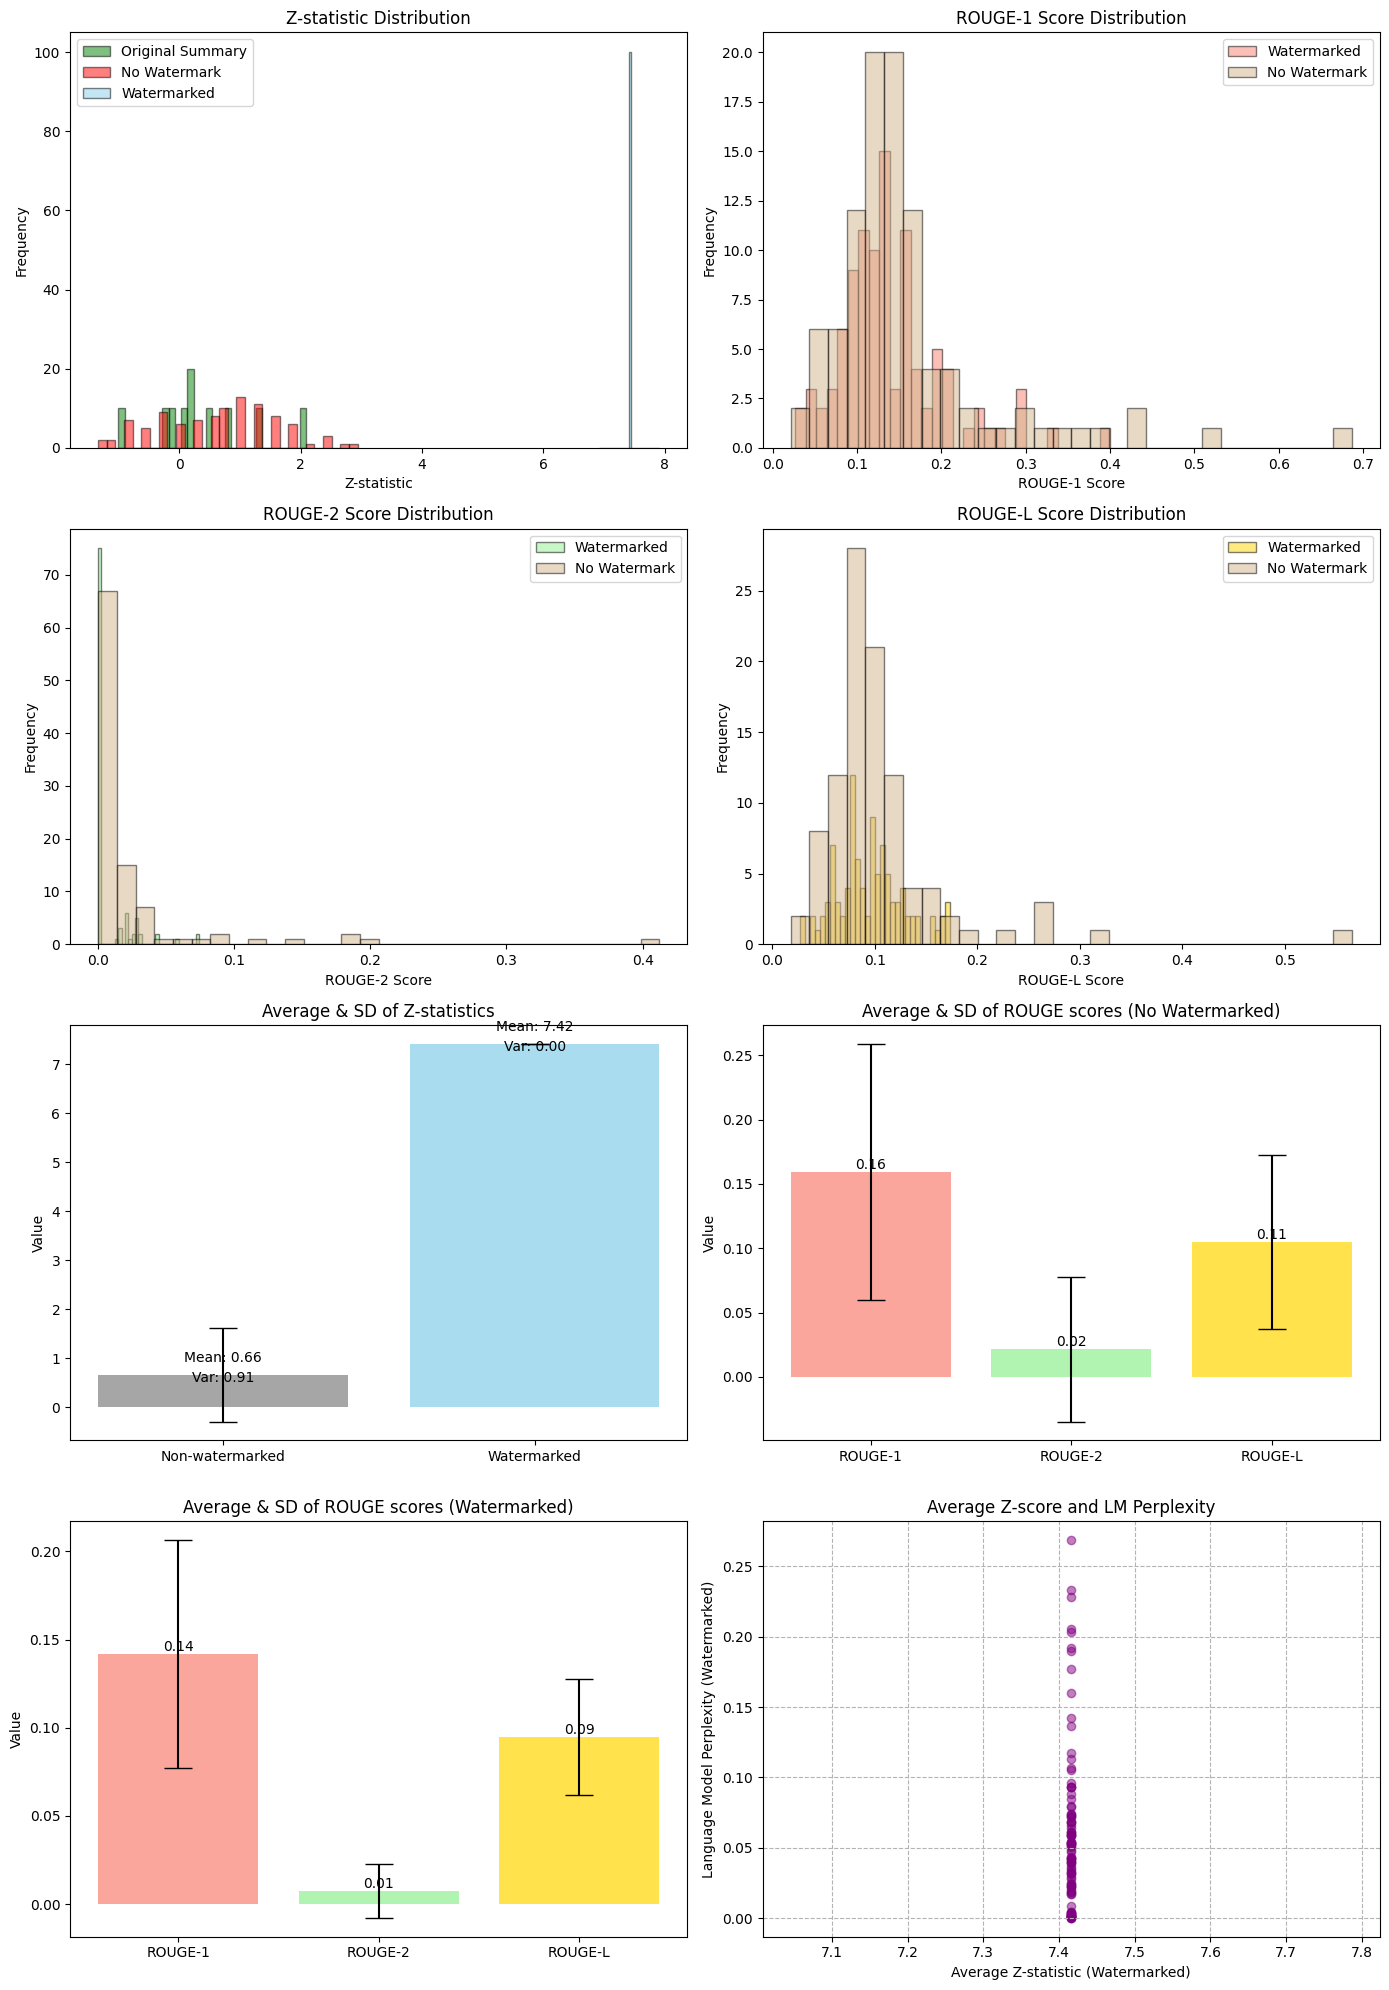

In [ ]:
df_2 = analyze_results(
original_summaries_2, nowatermark_summaries_2, watermarked_summaries_2,
            z_statistics_original_2, z_statistics_nowatermark_2, z_statistics_watermarked_2,
            rouge1_scores_watermarked_2,  rouge2_scores_watermarked_2, rougeL_scores_watermarked_2,
            rouge1_scores_nowatermark_2,rouge2_scores_nowatermark_2,rougeL_scores_nowatermark_2,perplexities_watermarked_2)

In [ ]:
df_2.head()

,Original Summary,No Watermarked Summary,Watermarked Summary,Z-statistic Original,Z-statistic No Watermark,Z-statistic Watermarked,ROUGE-1 Watermarked,ROUGE-2 Watermarked,ROUGE-L Watermarked,ROUGE-1 nowatermark,ROUGE-2 nowatermark,ROUGE-L nowatermark,Watermarked Perplexities
0,"The average cost of the big day has hit £25,00...",Debenhams and David's Bridal are two of the mo...,"DebBudget bridal stores such. as Monsoon, BHS ...",0.140028,1.870829,7.416198,0.333333,0.031250,0.121212,0.382353,0.090909,0.176471,0.000960
1,In the midst of the worst storm in New South W...,A waterfall gushing over Sydney's Harbour Brid...,<s>A couple of snow-breathing snow-breathing s...,2.092457,2.405351,7.416198,0.108108,0.000000,0.081081,0.294118,0.060000,0.117647,0.268814
2,"Ashley Pegram, from Summerville, South Carolin...","Ashley Pegram, 28, went on a date with Edward ...",<s>'The world's smallest dog' is a big fan. Th...,0.091670,-1.336306,7.416198,0.061069,0.015504,0.061069,0.427481,0.186047,0.259542,0.228373
3,Auctioneer gave painting an estimated value of...,Oil painting of a Catholic saint was believed ...,<s>A. lot more than just the. hands and knees ...,1.305460,-0.267261,7.416198,0.297030,0.000000,0.158416,0.686869,0.412371,0.565657,0.059430
4,"Thomas Brock, 30, was fatally shot following a...","Thomas Brock, 30, was shot dead at his home in...",<s>A. Police department is investigating claim...,-0.250000,-0.267261,7.416198,0.158416,0.000000,0.079208,0.520833,0.191489,0.312500,0.084834


**Z-statistic Distribution:**

This histogram showcases the distribution of Z-statistics for two categories: "Original Summary" and "Watermarked".
The majority of the data points for both categories lie close to the zero mark. However, the watermarked data displays a peak around the value of 5.9.

**ROUGE Score Distributions:**

The histograms depict the distribution of three different ROUGE scores (ROUGE-1, ROUGE-2, and ROUGE-L) for the "Watermarked" and "No Watermark" data.
For all three ROUGE score distributions, it is evident that the majority of scores are low, indicating potentially low overlap between the generated summaries and reference summaries. Compared to the Multinomial search strategy, the ROUGE scores are marginally higher. This suggests superior summarization quality for both watermarked and non-watermarked texts.

**Average & SD of Z-statistics:**

This bar chart displays the mean and variance of Z-statistics for both "Original" and "Watermarked" data.
The "Original" data has a mean close to zero, while the "Watermarked" data has a significantly higher mean, reinforcing the earlier observation from the Z-statistic distribution histogram.

**Average Z-Score and LM Perplexity:**

A scatter plot indicating a potential correlation or relationship between the average Z-statistic for "Watermarked" data and the language model perplexity.
Each dot represents an observation, and the vertical distribution of dots at specific Z-statistic values suggests multiple perplexity values for similar Z-scores.


In [ ]:
percentage = (df_2[df_2["Z-statistic Watermarked"] > 4].shape[0] / df_2.shape[0]) * 100

print(f"{percentage:.2f}% of Z-statistic Watermarked values are greater than 4.")

100.00% of Z-statistic Watermarked values are greater than 4.


# Algorithm 2 (Soft Watermak - Greedy)



In [ ]:
from collections import deque

@torch.no_grad()
def add_soft_watermark(model, input_ids,T=None, strategy='multinomial',gamma=0.5, delta=2, max_length=None, hash_function=hashlib.sha256):
    """
    Generate text using a model while obeying a "soft red list".

    Parameters:
    - model: A pretrained language model for text generation.
    - input_ids: Tensor containing the initial input for the generation.
    - gamma: Proportion for the green list.
    - delta: Hardness parameter.
    - max_length: Maximum length of the generated sequence.
    - hash_function: Hash function used for watermarking.

    Returns:
    - List of token IDs that adhere to the red list constraints.
    """

    vocab_size = model.config.vocab_size
    green_list_calculation = int(gamma * vocab_size)
    device = input_ids.device

    end_of_text_token_id = model.config.eos_token_id



    loop_limit = T

    # Preallocate tensor for efficiency
    decoder_input_ids = torch.zeros((1, loop_limit), dtype=torch.long, device=device)
    decoder_input_ids[0, 0] = model.config.bos_token_id

    watermarked_tokens = []

    for i in range(loop_limit-1):
        # 1. Apply the language model to prior tokens
        outputs = model(input_ids, decoder_input_ids=decoder_input_ids[:, :i+1])
        logits = outputs.logits[:, -1, :]

        # 2. Compute a hash of token and seed a random number generator
        hasher = hash_function()
        hasher.update(str(decoder_input_ids[0, i].item()).encode())
        digest = hasher.hexdigest()
        rng = random.Random(digest)

        # 3. Randomly partition the vocabulary into a green and red list
        green_tokens = [token for token in rng.sample(range(vocab_size), green_list_calculation)]


        # 4. Modify the logits according to the hardness parameter for green list tokens
        logits[0, green_tokens] += delta
        probabilities = F.softmax(logits, dim=-1)


        # Token generation based on strategy
        if strategy == 'multinomial':
            next_token = torch.multinomial(probabilities, 1).item()
        elif strategy == 'greedy':
            next_token = torch.argmax(probabilities).item()

        watermarked_tokens.append(next_token)
        decoder_input_ids[0, i+1] = next_token


        # Condition to break the loop if end-of-text token is reached and T is not defined
        if T is None and next_token == end_of_text_token_id:
            break


    return watermarked_tokens

In [ ]:
(original_summaries_3, nowatermark_summaries_3, watermarked_summaries_3,
            z_statistics_original_3, z_statistics_nowatermark_3, z_statistics_watermarked_3,
            rouge1_scores_watermarked_3,  rouge2_scores_watermarked_3, rougeL_scores_watermarked_3,
            rouge1_scores_nowatermark_3,rouge2_scores_nowatermark_3,rougeL_scores_nowatermark_3,perplexities_watermarked_3) = process_and_score_summaries(add_soft_watermark, cnn_docs, cnn_summaries, tokenizer, model,strategy='greedy',T=50)

Processing batches: 100%|███████████████████████████████████████████| 10/10 [14:00<00:00, 84.04s/it]


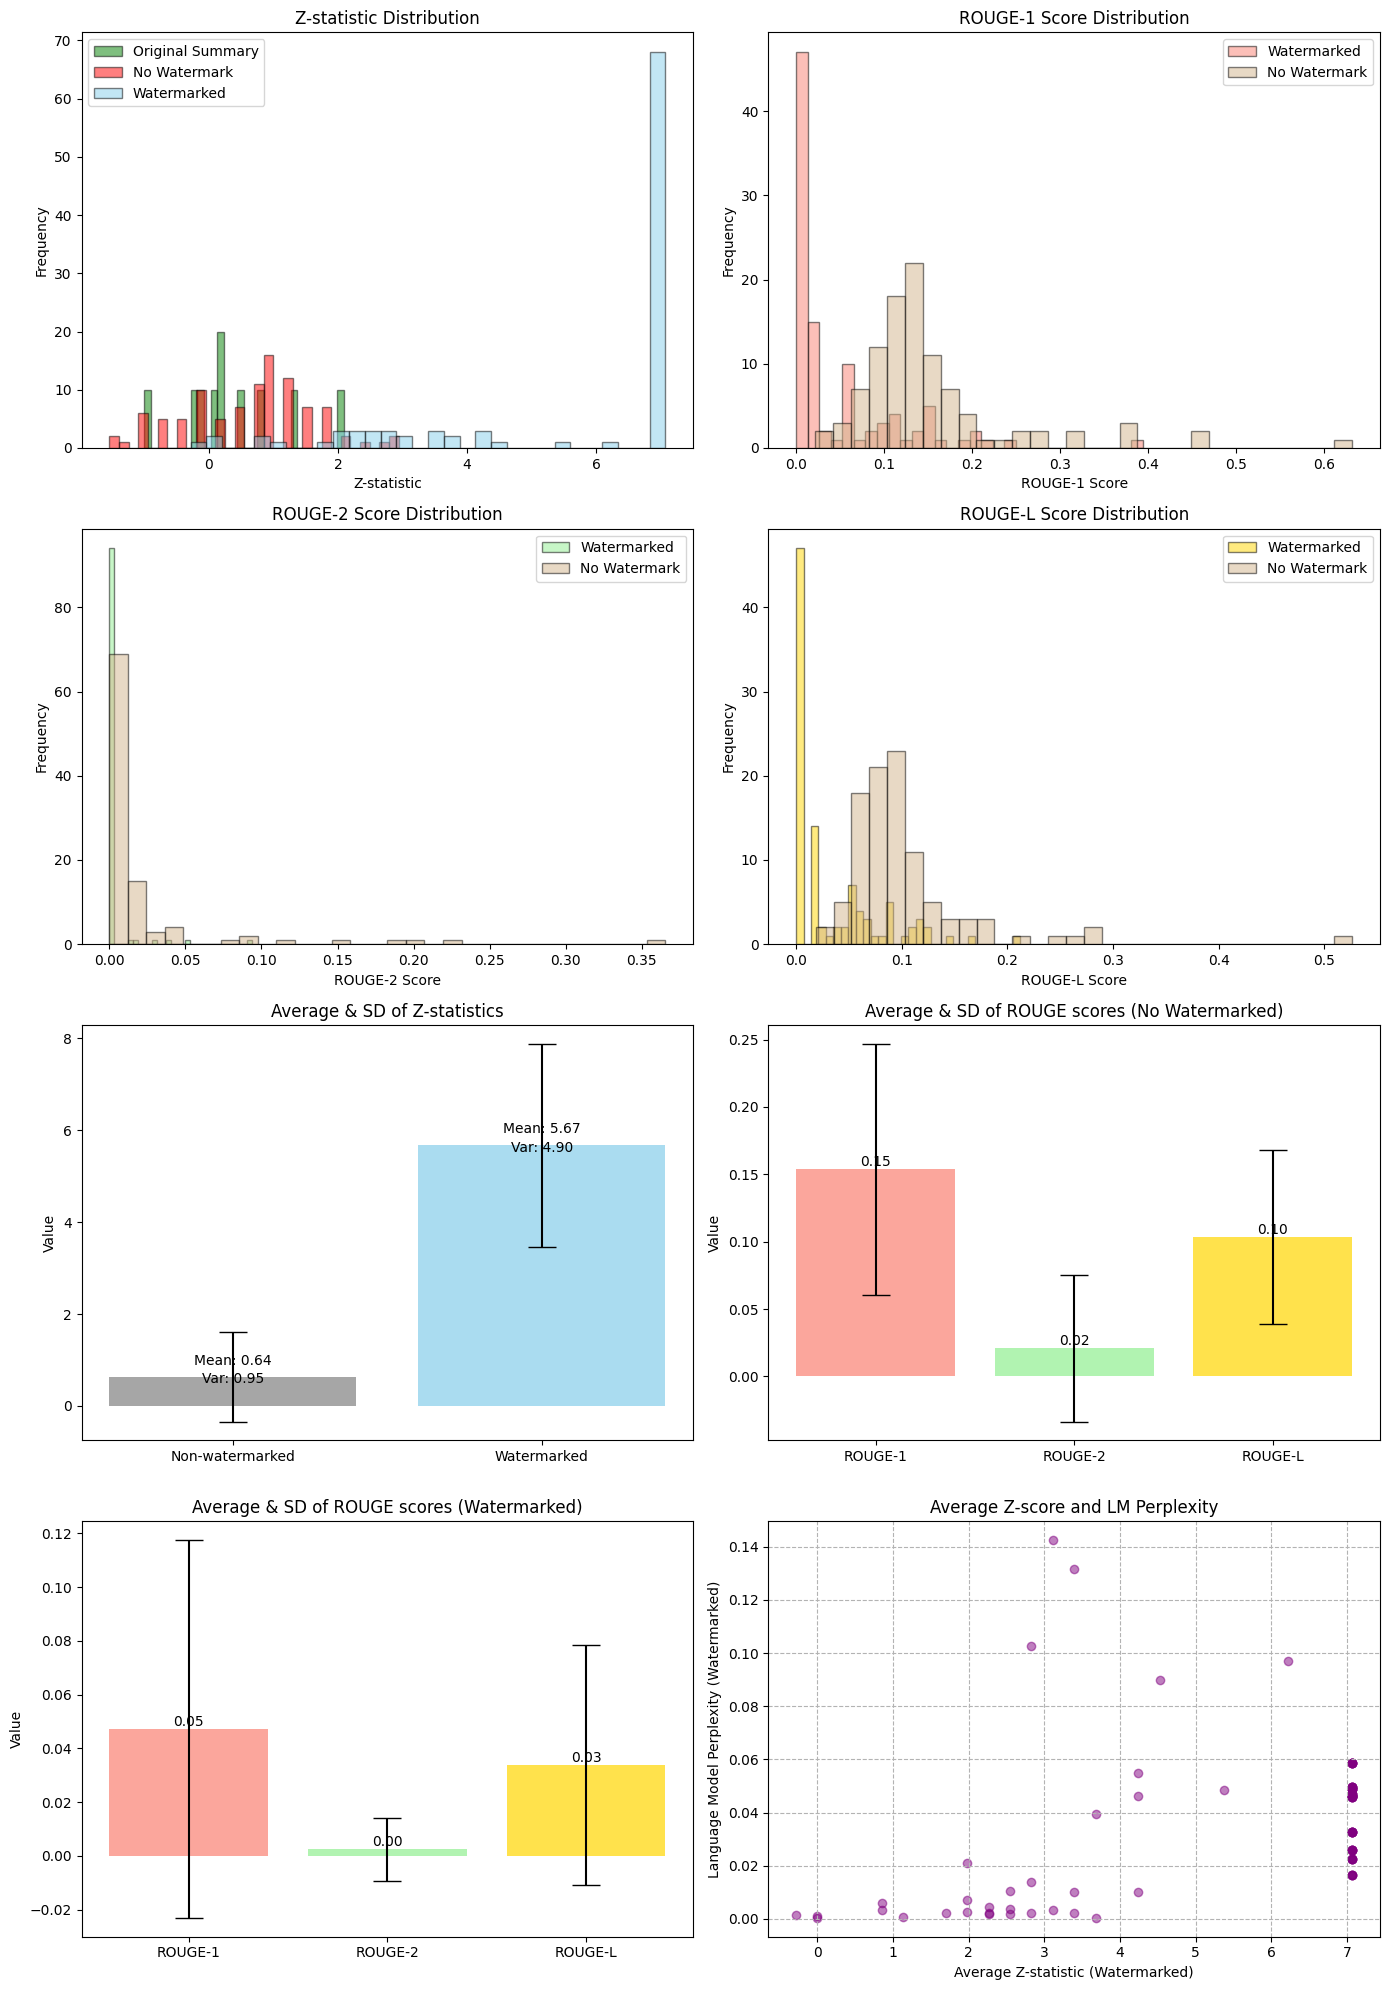

In [ ]:
df_3 = analyze_results(
original_summaries_3, nowatermark_summaries_3, watermarked_summaries_3,
            z_statistics_original_3, z_statistics_nowatermark_3, z_statistics_watermarked_3,
            rouge1_scores_watermarked_3,  rouge2_scores_watermarked_3, rougeL_scores_watermarked_3,
            rouge1_scores_nowatermark_3,rouge2_scores_nowatermark_3,rougeL_scores_nowatermark_3,perplexities_watermarked_3)

In [ ]:
df_3.head()

,Original Summary,No Watermarked Summary,Watermarked Summary,Z-statistic Original,Z-statistic No Watermark,Z-statistic Watermarked,ROUGE-1 Watermarked,ROUGE-2 Watermarked,ROUGE-L Watermarked,ROUGE-1 nowatermark,ROUGE-2 nowatermark,ROUGE-L nowatermark,Watermarked Perplexities
0,"The average cost of the big day has hit £25,00...",Debenhams and David's Bridal are two of the mo...,DebBudget bridal stores such as Monsoon and Da...,0.140028,1.820364,2.262742,0.393939,0.09375,0.212121,0.369231,0.095238,0.184615,0.001693
1,In the midst of the worst storm in New South W...,A waterfall gushing over Sydney's Harbour Brid...,<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><...,2.092457,2.660532,7.071068,0.019231,0.00000,0.019231,0.268041,0.042105,0.123711,0.025946
2,"Ashley Pegram, from Summerville, South Carolin...","Ashley Pegram, 28, went on a date with Edward ...",<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><...,0.091670,-0.700140,7.071068,0.000000,0.00000,0.000000,0.377953,0.192000,0.251969,0.025946
3,Auctioneer gave painting an estimated value of...,Oil painting of a Catholic saint was believed ...,<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><...,1.305460,-0.140028,7.071068,0.019417,0.00000,0.019417,0.631579,0.365591,0.526316,0.025946
4,"Thomas Brock, 30, was fatally shot following a...","Thomas Brock, 30, was shot dead at his home in...",<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><...,-0.250000,0.140028,7.071068,0.000000,0.00000,0.000000,0.456522,0.200000,0.282609,0.025946


**Utilizing a greedy search often results in the model frequently getting trapped on the \<s> token. This results in low ROUGE scores and poor quality. To counteract this, we can reduce the likelihood of recently chosen tokens being selected again.**

In [ ]:
from collections import deque

@torch.no_grad()
def add_soft_watermark_no_token_repetition(model, input_ids,T=None, strategy='multinomial',gamma=0.5, delta=2, max_length=None, hash_function=hashlib.sha256):
    """
    Generate text using a model while obeying a "soft red list".

    Parameters:
    - model: A pretrained language model for text generation.
    - input_ids: Tensor containing the initial input for the generation.
    - gamma: Proportion for the green list.
    - delta: Hardness parameter.
    - max_length: Maximum length of the generated sequence.
    - hash_function: Hash function used for watermarking.

    Returns:
    - List of token IDs that adhere to the red list constraints.
    """

    vocab_size = model.config.vocab_size
    green_list_calculation = int(gamma * vocab_size)
    device = input_ids.device

    end_of_text_token_id = model.config.eos_token_id



    loop_limit = T

    # Preallocate tensor for efficiency
    decoder_input_ids = torch.zeros((1, loop_limit), dtype=torch.long, device=device)
    decoder_input_ids[0, 0] = model.config.bos_token_id

    watermarked_tokens = []
    recent_tokens = deque(maxlen=5)
    for i in range(loop_limit-1):
        # 1. Apply the language model to prior tokens
        outputs = model(input_ids, decoder_input_ids=decoder_input_ids[:, :i+1])
        logits = outputs.logits[:, -1, :]

        # 2. Compute a hash of token and seed a random number generator
        hasher = hash_function()
        hasher.update(str(decoder_input_ids[0, i].item()).encode())
        digest = hasher.hexdigest()
        rng = random.Random(digest)

        # 3. Randomly partition the vocabulary into a green and red list
        green_tokens = [token for token in rng.sample(range(vocab_size), green_list_calculation)]


        # 4. Modify the logits according to the hardness parameter for green list tokens
        logits[0, green_tokens] += delta

        for token in recent_tokens:
            logits[0, token] = float('-inf')

        probabilities = F.softmax(logits, dim=-1)

        # Token generation based on strategy
        if strategy == 'multinomial':
            next_token = torch.multinomial(probabilities, 1).item()
        elif strategy == 'greedy':
            next_token = torch.argmax(probabilities).item()

        watermarked_tokens.append(next_token)

        # Add the generated token to the recent_tokens deque
        recent_tokens.append(next_token)
        decoder_input_ids[0, i+1] = next_token


        # Condition to break the loop if end-of-text token is reached and T is not defined
        if T is None and next_token == end_of_text_token_id:
            break


    return watermarked_tokens

We reduce the likelihood of the algorithm selecting previous tokens by decreasing the chances of picking recent ones. The range for recent tokens is adjustable. For this experiment, we used a width of 5.

In [ ]:
from tqdm import tqdm

(original_summaries_4, nowatermark_summaries_4, watermarked_summaries_4,
            z_statistics_original_4, z_statistics_nowatermark_4, z_statistics_watermarked_4,
            rouge1_scores_watermarked_4,  rouge2_scores_watermarked_4, rougeL_scores_watermarked_4,
            rouge1_scores_nowatermark_4,rouge2_scores_nowatermark_4,rougeL_scores_nowatermark_4,perplexities_watermarked_4) = process_and_score_summaries(add_soft_watermark_no_token_repetition, cnn_docs, cnn_summaries, tokenizer, model,gamma=0.5,delta=2,strategy='greedy',T=50)

Processing batches: 100%|███████████████████████████████████████████| 10/10 [14:15<00:00, 85.51s/it]


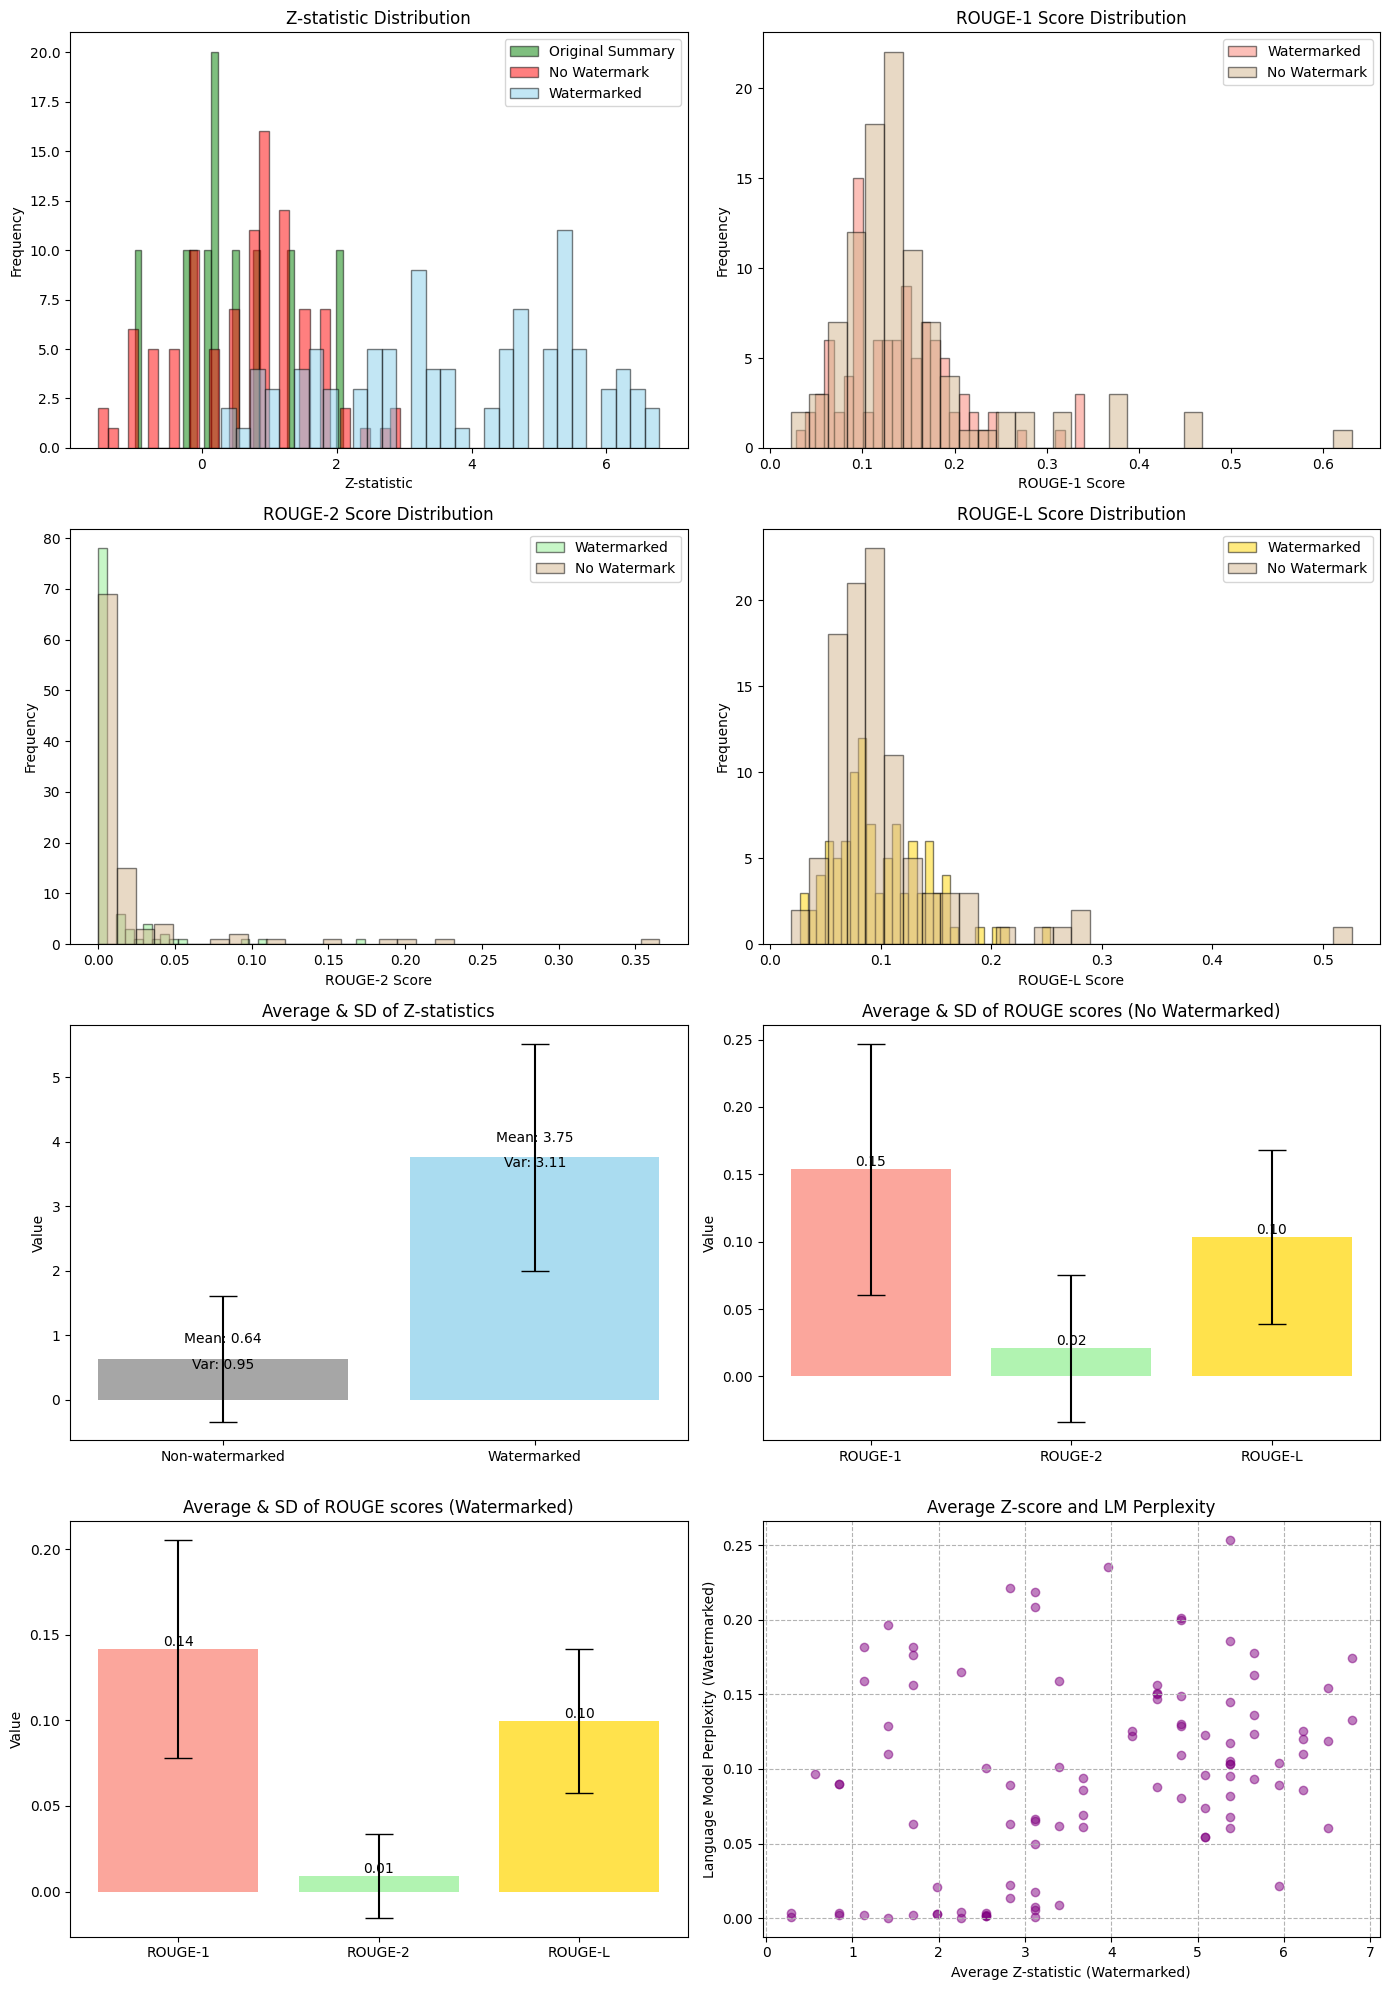

In [ ]:
df_4 = analyze_results(
original_summaries_4, nowatermark_summaries_4, watermarked_summaries_4,
            z_statistics_original_4, z_statistics_nowatermark_4, z_statistics_watermarked_4,
            rouge1_scores_watermarked_4,  rouge2_scores_watermarked_4, rougeL_scores_watermarked_4,
            rouge1_scores_nowatermark_4,rouge2_scores_nowatermark_4,rougeL_scores_nowatermark_4,perplexities_watermarked_4)

We can observe an slighltyly higher quality of summerization compare to hard list method.

**Z-statistic Distribution:**


The original and non-watermarked summaries closely align with each other, generally showcasing Z-statistics below 2 with the mean of 0.64. In contrast, watermarked summaries demonstrate a broader distribution, with an average value of 3.75.
A notable difference is observed between the watermarked and the non-watermarked data, indicating the influence of watermarking on the statistical characteristics of the summaries.

It can be noted that 47.00% of the watermarked data have Z-statistics exceeding 4, and 78% of them display Z-statistics greater than 2.


**ROUGE Score Distributions:**

The histograms for ROUGE-1, ROUGE-2, and ROUGE-L scores present their respective distributions for watermarked and non-watermarked summaries.
For all ROUGE metrics, watermarked summaries tend to have a lower frequency of higher scores compared to non-watermarked summaries. This suggests that watermarking affecting the quality of the summaries, as indicated by the ROUGE scores.

**Average & SD of Z-statistics:**

The watermarked texts have a notably higher mean Z-statistic and greater variance compared to the original texts.


**Average & SD of ROUGE Scores:**


Watermarked texts generally exhibit a lower average score across all ROUGE metrics compared to non-watermarked texts, and there is a noticeable variance in scores, especially for ROUGE-2.

**Average Z-score and LM Perplexity:**

The scatter plot visualizes the relationship between the average Z-statistic and the language model (LM) perplexity for watermarked texts. Each dot represents an instance, and it indicates that perplexity slighltly rises as Z-statistics increase.

In [ ]:
df_4.head()

,Original Summary,No Watermarked Summary,Watermarked Summary,Z-statistic Original,Z-statistic No Watermark,Z-statistic Watermarked,ROUGE-1 Watermarked,ROUGE-2 Watermarked,ROUGE-L Watermarked,ROUGE-1 nowatermark,ROUGE-2 nowatermark,ROUGE-L nowatermark,Watermarked Perplexities
0,"The average cost of the big day has hit £25,00...",Debenhams and David's Bridal are two of the mo...,DebBudget bridal stores such as Monsoon and Da...,0.140028,1.820364,2.545584,0.333333,0.093750,0.212121,0.369231,0.095238,0.184615,0.001413
1,In the midst of the worst storm in New South W...,A waterfall gushing over Sydney's Harbour Brid...,<s>A couple of the. deckers and a couple of th...,2.092457,2.660532,3.676955,0.276596,0.043478,0.191489,0.268041,0.042105,0.123711,0.068899
2,"Ashley Pegram, from Summerville, South Carolin...","Ashley Pegram, 28, went on a date with Edward ...",<s>'The world's smallest dog' is a big fan of ...,0.091670,-0.700140,5.374012,0.093750,0.015873,0.078125,0.377953,0.192000,0.251969,0.185695
3,Auctioneer gave painting an estimated value of...,Oil painting of a Catholic saint was believed ...,"<s>A. lot of the time, as a result of the. lac...",1.305460,-0.140028,5.091169,0.236559,0.000000,0.150538,0.631579,0.365591,0.526316,0.073824
4,"Thomas Brock, 30, was fatally shot following a...","Thomas Brock, 30, was shot dead at his home in...",<s>A. Police have now arrested brothers Steven...,-0.250000,0.140028,5.091169,0.315789,0.043011,0.147368,0.456522,0.200000,0.282609,0.054367


In [ ]:
percentage = (df_4[df_4["Z-statistic Watermarked"] > 4].shape[0] / df_4.shape[0]) * 100

print(f"{percentage:.2f}% of Z-statistic Watermarked values are greater than 4.")

47.00% of Z-statistic Watermarked values are greater than 4.


In [ ]:
percentage = (df_4[df_4["Z-statistic Watermarked"] > 2].shape[0] / df_4.shape[0]) * 100

print(f"{percentage:.2f}% of Z-statistic Watermarked values are greater than 2.")

78.00% of Z-statistic Watermarked values are greater than 2.


# Algorithm 2 (Soft Watermak - Multinomial)

In [ ]:
(original_summaries_5, nowatermark_summaries_5, watermarked_summaries_5,
            z_statistics_original_5, z_statistics_nowatermark_5, z_statistics_watermarked_5,
            rouge1_scores_watermarked_5,  rouge2_scores_watermarked_5, rougeL_scores_watermarked_5,
            rouge1_scores_nowatermark_5,rouge2_scores_nowatermark_5,rougeL_scores_nowatermark_5,perplexities_watermarked_5) = process_and_score_summaries(add_soft_watermark, cnn_docs, cnn_summaries, tokenizer, model,gamma=0.5,strategy='multinomial',T=50)

Processing batches: 100%|███████████████████████████████████████████| 10/10 [14:11<00:00, 85.20s/it]


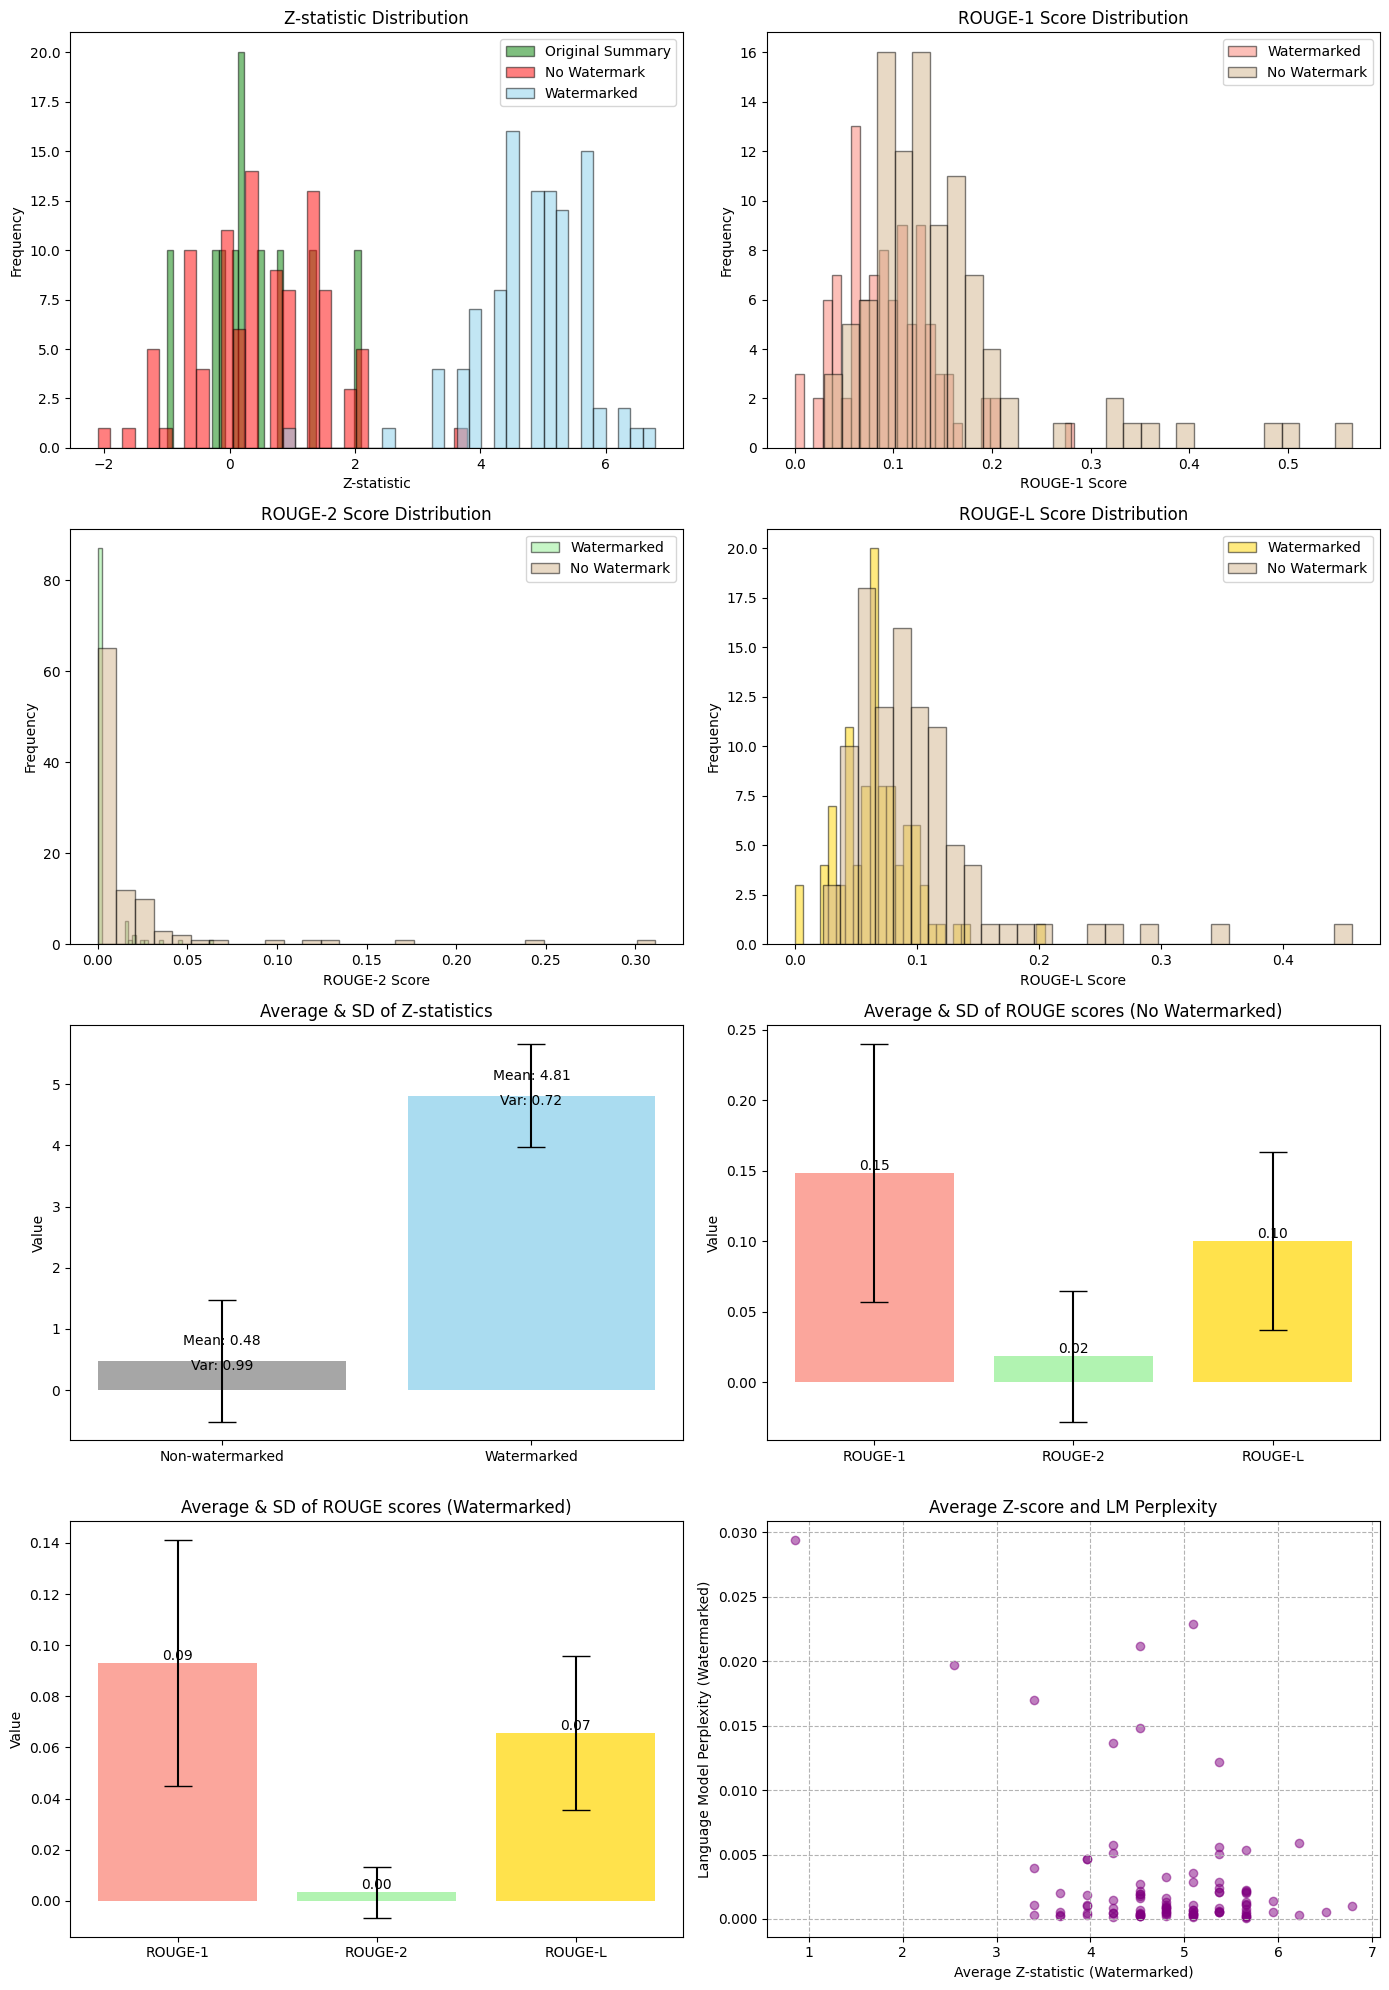

In [ ]:
df_5 = analyze_results(
original_summaries_5, nowatermark_summaries_5, watermarked_summaries_5,
            z_statistics_original_5, z_statistics_nowatermark_5, z_statistics_watermarked_5,
            rouge1_scores_watermarked_5,  rouge2_scores_watermarked_5, rougeL_scores_watermarked_5,
            rouge1_scores_nowatermark_5,rouge2_scores_nowatermark_5,rougeL_scores_nowatermark_5,perplexities_watermarked_5)

In [ ]:
df_5.head()

,Original Summary,No Watermarked Summary,Watermarked Summary,Z-statistic Original,Z-statistic No Watermark,Z-statistic Watermarked,ROUGE-1 Watermarked,ROUGE-2 Watermarked,ROUGE-L Watermarked,ROUGE-1 nowatermark,ROUGE-2 nowatermark,ROUGE-L nowatermark,Watermarked Perplexities
0,"The average cost of the big day has hit £25,00...",FEMAIL tests the two wedding dress brands agai...,DebBe prepared for the hottest of data�醒 on Mo...,0.140028,1.260252,4.525483,0.131148,0.0,0.131148,0.322581,0.033333,0.161290,0.000379
1,In the midst of the worst storm in New South W...,Social media users share Photoshopped photos a...,"Pass, and modifications for making a Nexus One...",2.092457,0.420084,5.091169,0.105263,0.0,0.063158,0.273684,0.043011,0.168421,0.000661
2,"Ashley Pegram, from Summerville, South Carolin...",Ash Ashley Pegram disappeared in New York on A...,<s>Dozensably- voicing- antivirus called virus...,0.091670,-0.700140,4.242641,0.032000,0.0,0.032000,0.323077,0.093750,0.184615,0.005749
3,Auctioneer gave painting an estimated value of...,painting of a Catholic saint thought to have ...,A bunch Volkswagen fame.Make your living money...,1.305460,1.540308,4.525483,0.129032,0.0,0.064516,0.565217,0.311111,0.456522,0.000317
4,"Thomas Brock, 30, was fatally shot following a...",Thomas Brock fatally shot at his home in Pasad...,MillSpr Suggestions Canadian$10 is a good star...,-0.250000,-0.140028,5.091169,0.043956,0.0,0.021978,0.494624,0.241758,0.344086,0.000416


In [ ]:
percentage = (df_5[df_5["Z-statistic Watermarked"] > 4].shape[0] / df_4.shape[0]) * 100

print(f"{percentage:.2f}% of Z-statistic Watermarked values are greater than 4.")

83.00% of Z-statistic Watermarked values are greater than 4.


**Z-statistic Distribution:**

The distribution of the watermarked summaries still seems to be skewed towards higher Z-statistics compared to the original and non-watermarked summaries, which remain clustered towards the lower end.

**ROUGE Score Distributions:**

In all three ROUGE score distributions (ROUGE-1, ROUGE-2, and ROUGE-L), watermarked summaries consistently showcase a broader spread than their non-watermarked counterparts.

The distribution peaks of the watermarked summaries in ROUGE-1 and ROUGE-L appear to be slightly to the right compared to the non-watermarked, suggesting potentially higher ROUGE scores on average for watermarked summaries in these metrics.

The ROUGE-2 Score Distribution seems to have fewer data points for watermarked summaries at higher scores than non-watermarked ones, indicating a possible decrease in the quality of watermarked summaries for this specific metric.

**Average & SD of Z-statistics:**

The mean Z-statistic for watermarked summaries is notably higher for multinomial algorithm (4.81) than in the previous one. Similarly, the variance has slightly increased. This might be due to the technique we incorporated using greedy search to avoid choosing repetitive tokens.


**Average Z-score and LM Perplexity:**

Since the majority of watermarked texts fall within the 2-7 range, we observe a concentration of Perplexity within that span. This indicates that using this method, most of the summaries exhibit comparable perplexity levels.

# Conclusion:

**Conclusion:**
As we endeavored to enhance the detectability of summaries using watermarking techniques, a decline in the summarization quality (indicated by ROUGE scores) was evident. Specifically, sentences with higher Z-statistics exhibit reduced quality.

To maintain the quality of the summarization while ensuring a reasonable detectability rate (78.00% by setting a Z-statistics threshold to 2), the soft list method combined with greedy search can be employed, alongside strategies to prevent token repetition. This approach results in a decrease in ROUGE-1 and ROUGE-2 scores from 0.15 and 0.02 to 0.14 and 0.01, respectively, while preserving the ROUGE-L score.

Conversely, to strike a balance between output quality and detectability, the soft list method with Multinomial search is recommended. With this method, a slight overlap between non-watermarked and watermarked texts is observed, and Z-statistics for all watermarked texts surpass the threshold of 2. This leads to a reduction in ROUGE-1, ROUGE-2, and ROUGE-L scores from 0.15, 0.02, and 0.10 to 0.09, 0, and 0.07, respectively.

It's worth noting that there are alternative and potentially superior search methods, such as Beam search, which are not the primary focus of this analysis. By optimizing the Gamma and Delta values, these methods might yield improved results.